In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

folder_path = r"C:\Users\apubh\Downloads\VDS2425 Football"
# CSV file load
csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

# Dictionary to store dataframes
data_frames = {}

# Read each CSV file and store it in the dictionary
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    data_frames[file] = pd.read_csv(file_path)
    print(f"Loaded: {file}")

Loaded: Country.csv
Loaded: League.csv
Loaded: Match.csv
Loaded: Match_Cards.csv
Loaded: Match_Corner.csv
Loaded: Match_Cross.csv


C:\Users\apubh\AppData\Local\Temp\ipykernel_21416\892627742.py:15: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data_frames[file] = pd.read_csv(file_path)


Loaded: Match_Fouls_Committed.csv
Loaded: Match_Goals.csv
Loaded: Match_Possesion.csv
Loaded: Match_Shots_Off.csv
Loaded: Match_Shots_On.csv
Loaded: Player.csv
Loaded: Player_Attributes.csv
Loaded: PositionReference.csv
Loaded: Team.csv
Loaded: Team_Attributes.csv



Top 11 Promising Young Players (Excluding Players from Atalanta):

                   overall_rating  potential    age
player_name                                        
Lionel Messi                88.88      94.38  21.38
Cristiano Ronaldo           89.67      93.33  22.33
Daniel Alves                80.00      92.00  23.00
Franck Ribery               85.00      92.00  23.00
Jesus Navas                 83.20      91.60  22.00
Wayne Rooney                89.25      91.50  21.75
Sergio Ramos                85.00      91.50  21.83
Fernando Torres             87.00      91.00  22.50
Yoann Gourcuff              79.33      90.83  21.83
Neymar                      83.54      90.62  20.67
Cesc Fabregas               86.78      90.44  21.22


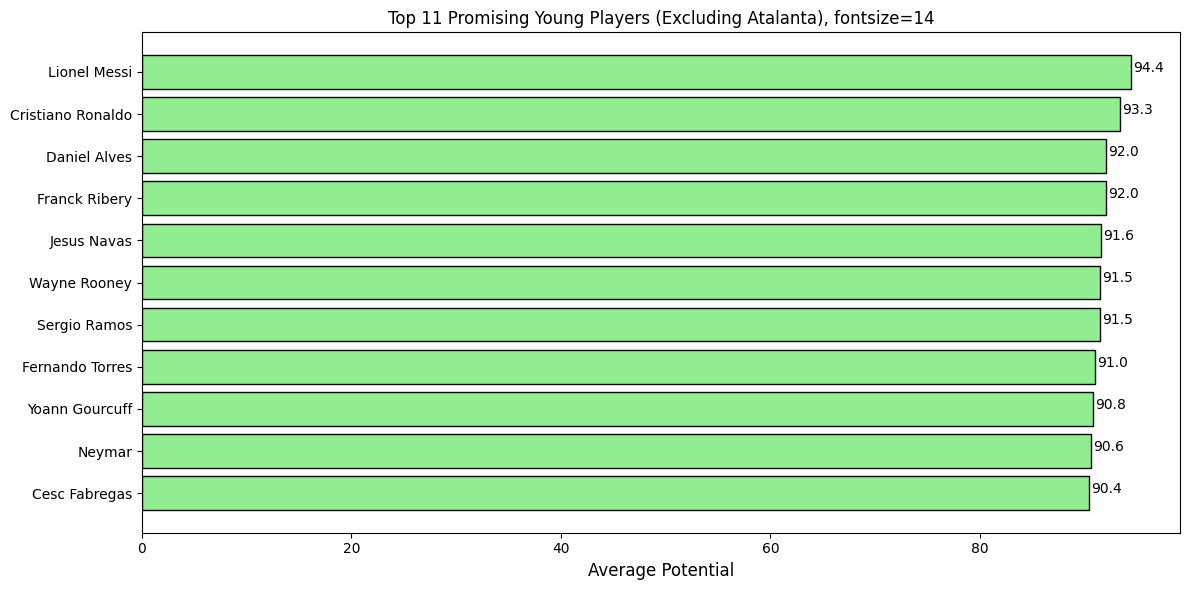

In [14]:
# The selected team
selected_team = "Atalanta"
match_df = data_frames["Match.csv"]
team_df = data_frames["Team.csv"]
player_df = data_frames["Player.csv"]
player_attr_df = data_frames["Player_Attributes.csv"]

# Merge player info with attributes
merged_df = pd.merge(player_attr_df, player_df, on="player_api_id")

# calculate age
merged_df["date"] = pd.to_datetime(merged_df["date"])
merged_df["birth_date"] = pd.to_datetime(merged_df["birthday"])
merged_df["age"] = (merged_df["date"] - merged_df["birth_date"]).dt.days // 365

# Filter under-23 players
young_players = merged_df[merged_df["age"] <= 23]

selected_team_id = team_df[team_df["team_long_name"] == selected_team]["team_api_id"].values[0]

team_matches = match_df[(match_df["home_team_api_id"] == selected_team_id) |
                        (match_df["away_team_api_id"] == selected_team_id)]


player_columns = [col for col in match_df.columns if "player" in col]
team_player_ids = set(team_matches[player_columns].values.ravel())
team_player_ids = {pid for pid in team_player_ids if not pd.isna(pid)}  


young_players = young_players[~young_players["player_api_id"].isin(team_player_ids)]


grouped = young_players.groupby("player_name").agg({
    "overall_rating": "mean",
    "potential": "mean",
    "age": "mean"
}).round(2)


top_young_players = grouped.sort_values("potential", ascending=False).head(11)
print(f"\nTop 11 Promising Young Players (Excluding Players from {selected_team}):\n")
print(top_young_players)

# Plot
top_young_players = top_young_players.reset_index()
plt.figure(figsize=(12, 6))
bars = plt.barh(top_young_players["player_name"], top_young_players["potential"], color="lightgreen", edgecolor="black")
plt.xlabel("Average Potential", fontsize=12)
plt.title(f"Top 11 Promising Young Players (Excluding {selected_team}), fontsize=14")
plt.gca().invert_yaxis()

for bar in bars:
    plt.text(bar.get_width() + 0.2, bar.get_y() + 0.3, f"{bar.get_width():.1f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()


In [15]:

matches = data_frames["Match.csv"]
teams = data_frames["Team.csv"]

# Convert match dates
matches["date"] = pd.to_datetime(matches["date"], dayfirst=True)
matches["season_year"] = matches["date"].dt.year

# Filter for 2008 to 2016
matches = matches[(matches["season_year"] >= 2008) & (matches["season_year"] <= 2016)]


def get_points(row, team_type):
    if row["home_team_goal"] > row["away_team_goal"]:
        return 3 if team_type == "home" else 0
    elif row["home_team_goal"] < row["away_team_goal"]:
        return 0 if team_type == "home" else 3
    else:
        return 1


home_df = matches[["season_year", "home_team_api_id", "home_team_goal", "away_team_goal"]].copy()
home_df["points"] = matches.apply(lambda row: get_points(row, "home"), axis=1)
home_df["team_id"] = home_df["home_team_api_id"]


away_df = matches[["season_year", "away_team_api_id", "away_team_goal", "home_team_goal"]].copy()
away_df["points"] = matches.apply(lambda row: get_points(row, "away"), axis=1)
away_df["team_id"] = away_df["away_team_api_id"]


home_df.rename(columns={"home_team_goal": "goals_for", "away_team_goal": "goals_against"}, inplace=True)
away_df.rename(columns={"away_team_goal": "goals_for", "home_team_goal": "goals_against"}, inplace=True)


all_perf = pd.concat([home_df, away_df])


seasonal_stats = all_perf.groupby(["season_year", "team_id"]).agg({
    "points": "sum",
    "goals_for": "sum",
    "goals_against": "sum"
}).reset_index()


seasonal_stats = pd.merge(seasonal_stats, teams[["team_api_id", "team_long_name"]],
                          left_on="team_id", right_on="team_api_id")


pivot = seasonal_stats[seasonal_stats["season_year"].isin([2008, 2016])]
pivot = pivot.pivot_table(index="team_long_name", columns="season_year", values="points")

# Drop teams that don't appear in both seasons
pivot = pivot.dropna()

# Calculate improvement (points in 2016 - points in 2008)
pivot["improvement"] = pivot[2016] - pivot[2008]

# Sort by improvement
pivot_sorted = pivot.sort_values("improvement", ascending=False)

# Display top improved teams
print("Top 10 Most Improved Teams (2008–2016):")
print(pivot_sorted.head(10).round(2))


Top 10 Most Improved Teams (2008–2016):
season_year      2008  2016  improvement
team_long_name                          
SL Benfica       26.0  57.0         31.0
Sporting CP      23.0  51.0         28.0
Real Madrid CF   29.0  54.0         25.0
Roma             23.0  48.0         25.0
Juventus         36.0  58.0         22.0
Atlético Madrid  30.0  50.0         20.0
Chievo Verona     9.0  28.0         19.0
Rio Ave FC       10.0  29.0         19.0
Napoli           30.0  47.0         17.0
FC Luzern        11.0  28.0         17.0


In [16]:

pivot = seasonal_stats[seasonal_stats["season_year"].isin([2014, 2016])]
pivot = pivot.pivot_table(index="team_long_name", columns="season_year", values="points")


pivot = pivot.dropna()

# Calculate improvement (2016 - 2014)
pivot["improvement"] = pivot[2016] - pivot[2014]

# Sort by improvement
pivot_sorted = pivot.sort_values("improvement", ascending=False)

# Display top improvers
print("Most Improved Teams (2014–2016):")
print(pivot_sorted.head(10).round(2))

Most Improved Teams (2014–2016):
season_year          2014  2016  improvement
team_long_name                              
Leicester City       13.0  42.0         29.0
Boavista FC          13.0  23.0         10.0
Real Betis Balompié  15.0  25.0         10.0
SM Caen              15.0  24.0          9.0
Bologna              14.0  23.0          9.0
Roda JC Kerkrade     11.0  18.0          7.0
Zagłębie Lubin       12.0  18.0          6.0
Dundee FC            21.0  25.0          4.0
Heart of Midlothian  25.0  29.0          4.0
FC Arouca            31.0  35.0          4.0


In [17]:

def get_result(row):
    if row["home_team_api_id"] == selected_team_id:
        if row["home_team_goal"] > row["away_team_goal"]:
            return "Win"
        elif row["home_team_goal"] < row["away_team_goal"]:
            return "Loss"
        else:
            return "Draw"
    else:
        if row["away_team_goal"] > row["home_team_goal"]:
            return "Win"
        elif row["away_team_goal"] < row["home_team_goal"]:
            return "Loss"
        else:
            return "Draw"

team_matches["result"] = team_matches.apply(get_result, axis=1)

# Identify opponent team in each match
team_matches["opponent_team_api_id"] = team_matches.apply(
    lambda row: row["away_team_api_id"] if row["home_team_api_id"] == selected_team_id else row["home_team_api_id"],
    axis=1
)

# Group by opponent and result
result_counts = team_matches.groupby(["opponent_team_api_id", "result"]).size().unstack(fill_value=0)

# Add total matches and win rate
result_counts["Total"] = result_counts.sum(axis=1)
result_counts["Win %"] = (result_counts["Win"] / result_counts["Total"] * 100).round(2)

# Merge with team names
result_counts = result_counts.reset_index().merge(
    team_df[["team_api_id", "team_long_name"]],
    left_on="opponent_team_api_id",
    right_on="team_api_id",
    how="left"
)

# Final table
result_counts = result_counts[["team_long_name", "Win", "Draw", "Loss", "Total", "Win %"]]
result_counts = result_counts.sort_values("Win %", ascending=False)

# Show best and worst 5
print("\n Best opponents (highest win rate):")
print(result_counts.head())

print("\n Toughest opponents (lowest win rate):")
print(result_counts.tail())



 Best opponents (highest win rate):
   team_long_name  Win  Draw  Loss  Total  Win %
21         Cesena    3     1     0      4  75.00
2        Cagliari    7     2     2     11  63.64
10          Siena    5     1     2      8  62.50
7         Livorno    2     0     2      4  50.00
20        Pescara    1     1     0      2  50.00

 Toughest opponents (lowest win rate):
     team_long_name  Win  Draw  Loss  Total  Win %
6        Fiorentina    2     1    11     14  14.29
28            Genoa    2     7     5     14  14.29
15  Reggio Calabria    0     0     2      2   0.00
19    Hellas Verona    0     2     4      6   0.00
23         Juventus    0     1    13     14   0.00


C:\Users\apubh\AppData\Local\Temp\ipykernel_21416\1734228151.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_matches["result"] = team_matches.apply(get_result, axis=1)
C:\Users\apubh\AppData\Local\Temp\ipykernel_21416\1734228151.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_matches["opponent_team_api_id"] = team_matches.apply(


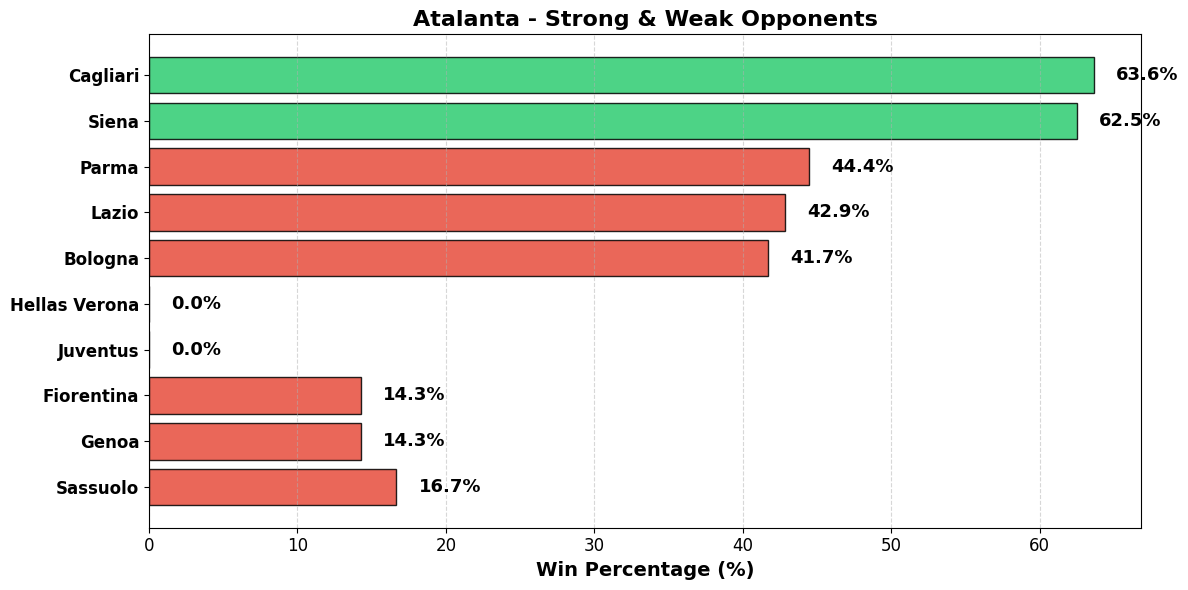

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Strong vs. Weak Opponents

combined_teams = pd.concat([
    result_counts[result_counts["Total"] >= 5].sort_values("Win %", ascending=False).head(5),
    result_counts[result_counts["Total"] >= 5].sort_values("Win %", ascending=True).head(5)
])


colors = ["#2ecc71" if win >= 50 else "#e74c3c" for win in combined_teams["Win %"]]

# Bar chart highlighting teams with the highest and lowest win rates.

plt.figure(figsize=(12, 6))
bars = plt.barh(combined_teams["team_long_name"], combined_teams["Win %"], color=colors, edgecolor="black", alpha=0.85)


plt.xlabel("Win Percentage (%)", fontsize=14, fontweight='bold')
plt.title(f"{selected_team} - Strong & Weak Opponents", fontsize=16, fontweight='bold')


plt.gca().invert_yaxis()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, fontweight='bold')


for bar in bars:
    plt.text(bar.get_width() + 1.5, bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.1f}%", va='center', fontsize=13, fontweight='bold')

plt.grid(axis="x", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

C:\Users\apubh\AppData\Local\Temp\ipykernel_21416\3282270252.py:15: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  match_df["date"] = pd.to_datetime(match_df["date"], errors="coerce")


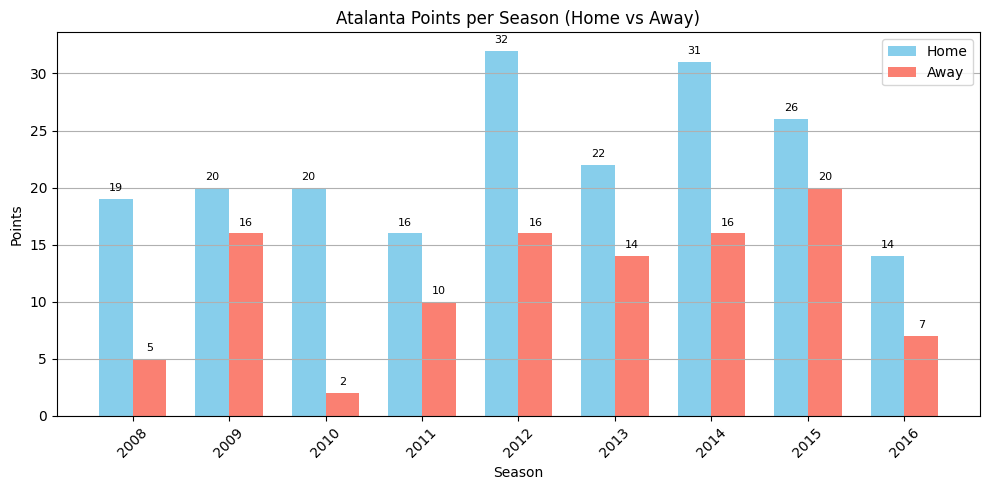

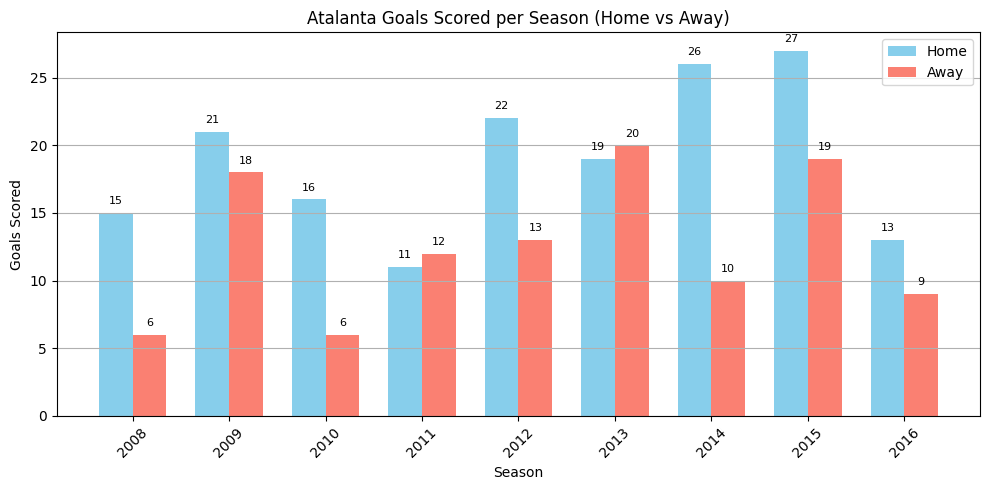

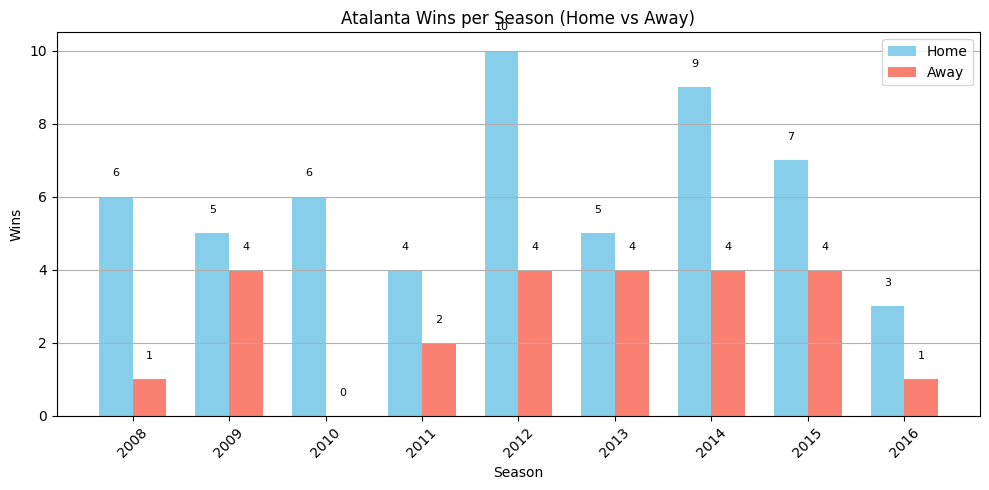

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

folder_path = r"C:\Users\apubh\Downloads\VDS2425 Football"
match_df = pd.read_csv(os.path.join(folder_path, "Match.csv"))
team_df = pd.read_csv(os.path.join(folder_path, "Team.csv"))


atalanta_row = team_df[team_df["team_long_name"].str.contains("Atalanta", case=False, na=False)]
atalanta_id = atalanta_row["team_api_id"].values[0]


match_df["date"] = pd.to_datetime(match_df["date"], errors="coerce")
match_df["season"] = match_df["date"].dt.year
# Home vs. Away Match Comparison
def process_team_matches(df, team_id, side):
    if side == "home":
        mask = df["home_team_api_id"] == team_id
        df_filtered = df[mask].copy()
        df_filtered["side"] = "Home"
        df_filtered["points"] = df_filtered.apply(
            lambda row: 3 if row["home_team_goal"] > row["away_team_goal"]
            else 1 if row["home_team_goal"] == row["away_team_goal"] else 0, axis=1
        )
        df_filtered["goals_scored"] = df_filtered["home_team_goal"]
        df_filtered["win"] = df_filtered["points"] == 3
    else:
        mask = df["away_team_api_id"] == team_id
        df_filtered = df[mask].copy()
        df_filtered["side"] = "Away"
        df_filtered["points"] = df_filtered.apply(
            lambda row: 3 if row["away_team_goal"] > row["home_team_goal"]
            else 1 if row["away_team_goal"] == row["home_team_goal"] else 0, axis=1
        )
        df_filtered["goals_scored"] = df_filtered["away_team_goal"]
        df_filtered["win"] = df_filtered["points"] == 3

    return df_filtered[["season", "side", "points", "goals_scored", "win"]]


home_matches = process_team_matches(match_df, atalanta_id, "home")
away_matches = process_team_matches(match_df, atalanta_id, "away")
atalanta_matches = pd.concat([home_matches, away_matches])


summary = atalanta_matches.groupby(["season", "side"]).agg({
    "points": "sum",
    "goals_scored": "sum",
    "win": "sum"
}).reset_index().rename(columns={"win": "wins"})


metrics = ["points", "goals_scored", "wins"]
# Stacked bar chart displaying performance metrics (wins, goals, points) per season.

for metric in metrics:
    pivot = summary.pivot(index="season", columns="side", values=metric).fillna(0)
    seasons = pivot.index.astype(str)
    x = np.arange(len(seasons))

    width = 0.35
    fig, ax = plt.subplots(figsize=(10, 5))
    bars1 = ax.bar(x - width/2, pivot["Home"], width, label="Home", color="skyblue")
    bars2 = ax.bar(x + width/2, pivot["Away"], width, label="Away", color="salmon")

    ax.set_xlabel("Season")
    ax.set_ylabel(metric.replace("_", " ").title())
    ax.set_title(f"Atalanta {metric.replace('_', ' ').title()} per Season (Home vs Away)")
    ax.set_xticks(x)
    ax.set_xticklabels(seasons, rotation=45)
    ax.legend()
    ax.grid(True, axis='y')


    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.5, f"{height:.0f}", 
                ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()


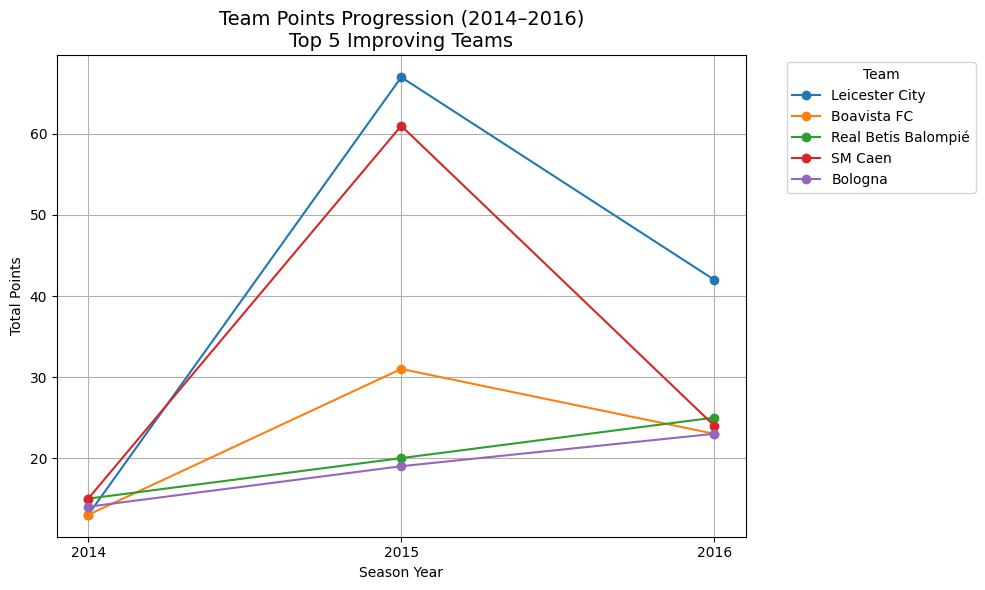

In [ ]:
import matplotlib.pyplot as plt
#Team Performance Over Seasons
years = (2014, 2016)
pivot = seasonal_stats[seasonal_stats["season_year"].isin(years)]
pivot = pivot.pivot_table(index="team_long_name", columns="season_year", values="points").dropna()
pivot["improvement"] = pivot[years[1]] - pivot[years[0]]
top_teams = pivot.sort_values("improvement", ascending=False).head(5).index.tolist()

progress_subset = seasonal_stats[
    (seasonal_stats["team_long_name"].isin(top_teams)) &
    (seasonal_stats["season_year"].isin([2014, 2015, 2016]))
]


# Line graph visualizing points progression from 2014 to 2016.

plt.figure(figsize=(10, 6))
for team in top_teams:
    team_data = progress_subset[progress_subset["team_long_name"] == team]
    plt.plot(team_data["season_year"], team_data["points"], marker="o", label=team)

plt.title("Team Points Progression (2014–2016)\nTop 5 Improving Teams", fontsize=14)
plt.xlabel("Season Year")
plt.ylabel("Total Points")
plt.xticks([2014, 2015, 2016])
plt.grid(True)
plt.legend(title="Team", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("Team_Progression_2014_2016.png", dpi=300)
plt.show()


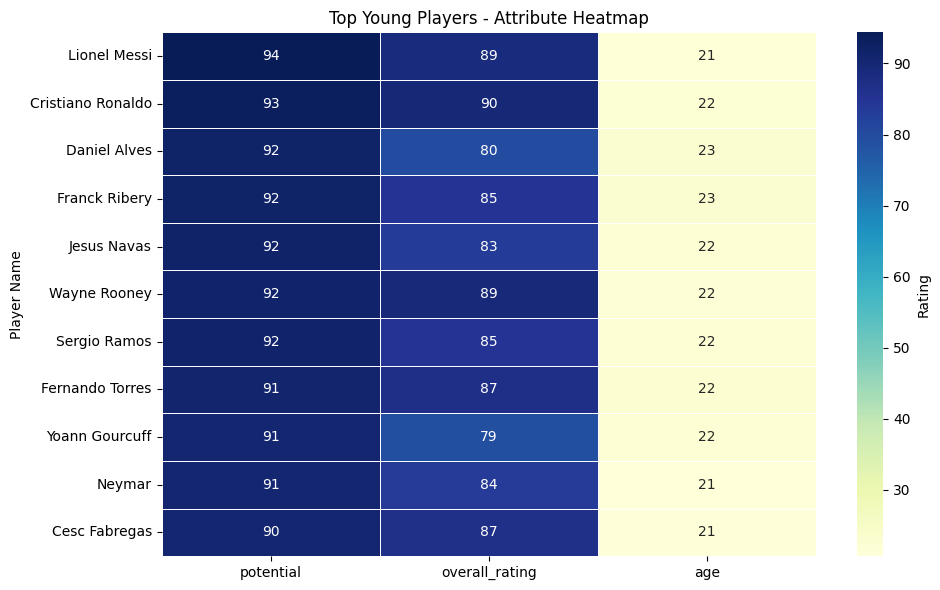

In [ ]:
import seaborn as sns
# Player Performance & Promising Young Stars
# Select relevant stats for top 10 players
heat_data = top_young_players[["potential", "overall_rating", "age"]].set_index(top_young_players["player_name"])
# Heatmap showcasing key player attributes such as potential and ratings.

plt.figure(figsize=(10, 6))
sns.heatmap(heat_data, annot=True, cmap="YlGnBu", linewidths=0.5, cbar_kws={"label": "Rating"})
plt.title("Top Young Players - Attribute Heatmap")
plt.ylabel("Player Name")
plt.tight_layout()
plt.show()


C:\Users\apubh\AppData\Local\Temp\ipykernel_21416\3244962387.py:5: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  match_df["date"] = pd.to_datetime(match_df["date"], errors="coerce")



📊 Atalanta Seasonal Performance (2008–2016):
   season  points  goals  wins
0    2008      24     21     7
1    2009      36     39     9
2    2010      22     22     6
3    2011      26     23     6
4    2012      48     35    14
5    2013      36     39     9
6    2014      47     36    13
7    2015      46     46    11
8    2016      21     22     4


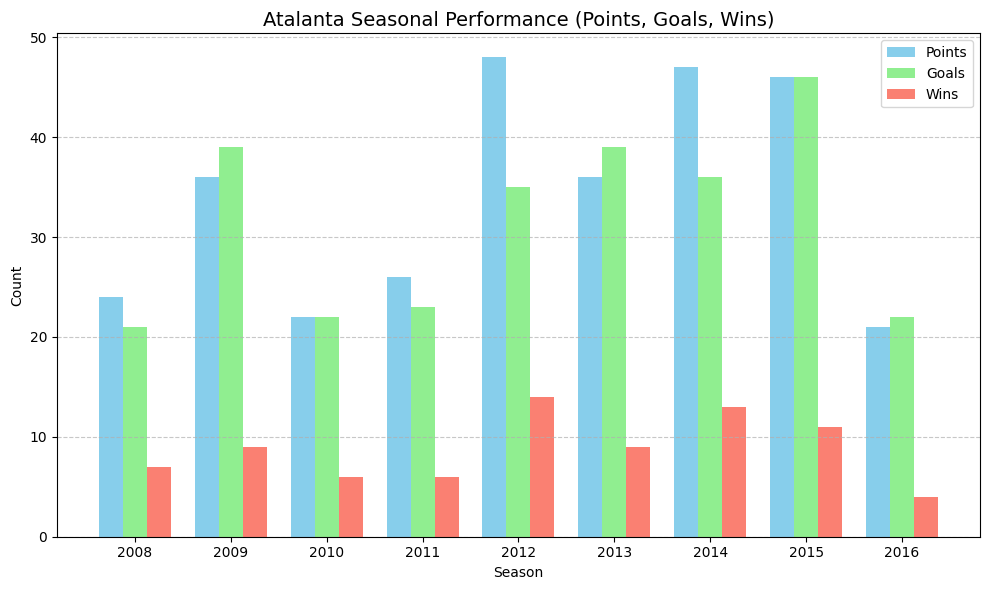

In [ ]:
# Team Performance Over Seasons
folder_path = r"C:\Users\apubh\Downloads\VDS2425 Football"
match_df = pd.read_csv(os.path.join(folder_path, "Match.csv"))
team_df = pd.read_csv(os.path.join(folder_path, "Team.csv"))

match_df["date"] = pd.to_datetime(match_df["date"], errors="coerce")
match_df["season"] = match_df["date"].dt.year

# Get Atalanta team ID
atalanta_id = team_df[team_df["team_long_name"].str.contains("Atalanta", case=False, na=False)]["team_api_id"].values[0]

def process_matches(df, team_id, side):
    if side == "home":
        mask = df["home_team_api_id"] == team_id
        df_side = df[mask].copy()
        df_side["points"] = df_side.apply(
            lambda r: 3 if r["home_team_goal"] > r["away_team_goal"]
            else 1 if r["home_team_goal"] == r["away_team_goal"]
            else 0, axis=1
        )
        df_side["goals"] = df_side["home_team_goal"]
        df_side["win"] = df_side["points"] == 3
    else:
        mask = df["away_team_api_id"] == team_id
        df_side = df[mask].copy()
        df_side["points"] = df_side.apply(
            lambda r: 3 if r["away_team_goal"] > r["home_team_goal"]
            else 1 if r["away_team_goal"] == r["home_team_goal"]
            else 0, axis=1
        )
        df_side["goals"] = df_side["away_team_goal"]
        df_side["win"] = df_side["points"] == 3

    return df_side[["season", "points", "goals", "win"]]

home = process_matches(match_df, atalanta_id, "home")
away = process_matches(match_df, atalanta_id, "away")
atalanta_matches = pd.concat([home, away])


seasonal_stats = atalanta_matches.groupby("season").agg({
    "points": "sum",
    "goals": "sum",
    "win": "sum"
}).reset_index().rename(columns={"win": "wins"})

print("\n📊 Atalanta Seasonal Performance (2008–2016):")
print(seasonal_stats)

# Line graph visualizing points progression from 2014 to 2016.

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(seasonal_stats["season"] - 0.25, seasonal_stats["points"], width=0.25, label="Points", color="skyblue")
ax.bar(seasonal_stats["season"], seasonal_stats["goals"], width=0.25, label="Goals", color="lightgreen")
ax.bar(seasonal_stats["season"] + 0.25, seasonal_stats["wins"], width=0.25, label="Wins", color="salmon")

ax.set_xticks(seasonal_stats["season"])
ax.set_xlabel("Season")
ax.set_ylabel("Count")
ax.set_title("Atalanta Seasonal Performance (Points, Goals, Wins)", fontsize=14)
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
